# Recognize epileptic seizures in EEG

### Theoretical notes on DFT

$$y[k] = \sum_{n=0}^{N-1} x[n] e^{-i \frac{2 \pi}{N} n k}$$

$$x[n] = \frac{1}{N} \left( \sum_{k=0}^{N-1} y[k] e^{i \frac{2 \pi}{N} n k} \right)$$
* DFT takes a signal in temporal domain $[0;  N*T_{sampling}]$  and represents it in frequency domain $[0; F_{sampling}]$.
* *Intuition*:
    * The term $e^{-i \frac{2 \pi}{N}}$ defines an elementary angle of $\frac{2\pi}{N}$ radians on the unit circle and its integer powers are multiples of the angle.
    * To reveal harmonics hidden in a signal we sum its sample points weighted with some vectors from the unit circle.
    * The vectors will "rotate" as we go from one sample point to another.
    * We will try all possible rotation frequencies $f \in \left\{0, \frac{F_{sampling}}{N}, \frac{2 F_{sampling}}{N}, ..., \frac{(N-1)F_{sampling}}{N} \right\}$.
    * When the rotation frequency will match an inherent frequency of the signal, the weighted sum will have large absolute values.
* In practice the time series is always real-valued. In this case it is enough to consider only the first half of the frequencies, because the second half will be symmetric to the first and thus will bring no new information.

### Prepare data subsets

In [1]:
from IPython.display import display, Markdown

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = '../data'
LABELS = ('Z', 'O', 'N', 'F', 'S')

def read_set(code):
    with open(os.path.join(DATA_PATH, code + '.npy'), "rb") as f:
        return np.load(f)

subsets = [
    {'data': read_set(l), 'label': l}
    for l in LABELS
]

### Dataset

In [3]:
from scipy.fftpack import fft, fftfreq
import pywt
from sklearn.preprocessing import LabelEncoder

t = 23.6
N = 4097
Fs = N / t
print(f"sampling frequency: {Fs:.1f} Hz")
print(f"sampling period: {1 / Fs:.3f} sec")


def get_fft_values(X, Fs, N):
    f_values = fftfreq(N, d=1 / Fs)[0:N//2]
    fft_values_ = fft(X)
    fft_values = 2.0/N * np.abs(fft_values_[:, 0:N//2])
    return f_values, fft_values


def prepare_dataset(subsets, transform=None):
    xs = []
    for s in subsets:
        x = s['data']
        if transform == 'fourier':
            _, x = get_fft_values(x, Fs, N)
        elif transform == 'wavelet':
            x = np.concatenate(pywt.wavedec(x, 'rbio3.5'), axis=1)
        xs.append(x)
    features = np.concatenate(xs, axis=0)

    labels = np.concatenate([
        [s['label']] * len(s['data']) for s in subsets
    ], axis=0)

    label_encoder = LabelEncoder()
    label_encoder.fit_transform(labels)
    
    return features, labels, label_encoder

sampling frequency: 173.6 Hz
sampling period: 0.006 sec


### Classify EEG segments

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [5]:
def split_dataset(X, mask):
    return X[~mask], X[mask]


def test_dataset(features, labels, test_mask):
    model = RandomForestClassifier(random_state=0)
    scores = cross_val_score(
        model, features, labels, 
        scoring='accuracy', 
        cv=5, 
        n_jobs=-1,
    )
    print(f"CV accuracy: mu={np.mean(scores):.2f}, std={np.std(scores):.2f}")
    
    X, X_test = split_dataset(features, test_mask)
    y, y_test = split_dataset(labels, test_mask)
    
    model = RandomForestClassifier(random_state=0)
    model.fit(X, y)

    y_pred = model.predict(X_test)
    show_confusion(y_test, y_pred)


def show_confusion(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred, labels=LABELS)
    cf_df = pd.DataFrame(cf_matrix, index=LABELS, columns=LABELS)
    sns.heatmap(cf_df, annot=True)
    plt.show()

Initial signal values
CV accuracy: mu=0.65, std=0.03


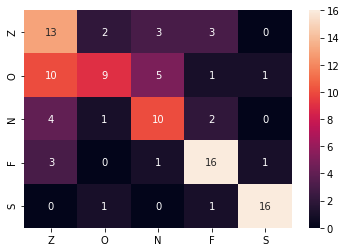

Fourier transform
CV accuracy: mu=0.83, std=0.03


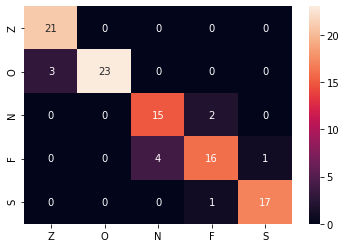

Wavelet transform
CV accuracy: mu=0.77, std=0.03


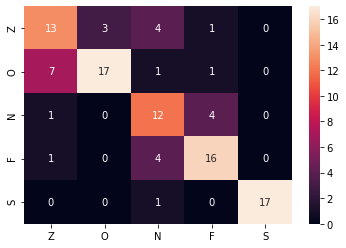

In [6]:
X, y, _ = prepare_dataset(subsets)
Xf, yf, _ = prepare_dataset(subsets, transform='fourier')
Xw, yw, _ = prepare_dataset(subsets, transform='wavelet')

test_size = 0.2
test_mask = np.random.choice(2, size=len(y), p=[1-test_size, test_size]).astype(bool)

print('Initial signal values')
test_dataset(X, y, test_mask)
print('Fourier transform')
test_dataset(Xf, yf, test_mask)
print('Wavelet transform')
test_dataset(Xw, yw, test_mask)

### Continuous wavelet transform + CNN

In [7]:
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()

signal, labels, _ = prepare_dataset(subsets)
coefs, _ = pywt.cwt(signal, scales=np.arange(1, 129), wavelet='gaus5', sampling_period=1/Fs)
X = np.swapaxes(coefs, 0, 1)
y = label_encoder.fit_transform(labels)

X_train, X_val = split_dataset(X, test_mask)
y_train, y_val = split_dataset(y, test_mask)

def make_dataset(x, y):
    data = torch.tensor(x.astype(np.float32)).unsqueeze(1)
    return TensorDataset(data, torch.tensor(y))

dataset_train = make_dataset(X_train, y_train)
dataset_val = make_dataset(X_val, y_val)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl

class Net(pl.LightningModule):
    def __init__(self, dataset, dataset_val):
        super(Net, self).__init__()
        self.pool2 = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(1, 2, 5)
        self.conv2 = nn.Conv2d(2, 1, 5)
        self.conv3 = nn.Conv2d(1, 1, 3)
        self.conv4 = nn.Conv2d(1, 1, 3)
        self.dropout = nn.Dropout(p=0.9)
        self.fc1 = nn.Linear(1265, 32)
        self.fc2 = nn.Linear(32, 5)
        
        self.dataset = dataset
        self.dataset_val = dataset_val

    def forward(self, x):
        x = self.pool2(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = self.pool2(F.relu(self.conv4(x)))
        x = self.dropout(x.view(-1, 1265))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.argmax(y_hat, axis=1)
        acc = (pred == y).type(torch.float).mean()
        self.log("val_acc", acc)
        self.log("val_loss", loss)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        loader = DataLoader(self.dataset, batch_size=32, shuffle=True)
        return loader
    
    def val_dataloader(self):
        loader = DataLoader(self.dataset_val, batch_size=32, shuffle=False)
        return loader


model = Net(dataset_train, dataset_val)

In [9]:
trainer = pl.Trainer(gpus=1, max_epochs=256)
trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name    | Type      | Params
--------------------------------------
0 | pool2   | MaxPool2d | 0     
1 | conv1   | Conv2d    | 52    
2 | conv2   | Conv2d    | 51    
3 | conv3   | Conv2d    | 10    
4 | conv4   | Conv2d    | 10    
5 | dropout | Dropout   | 0     
6 | fc1     | Linear    | 40.5 K
7 | fc2     | Linear    | 165   
--------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)
/home/maxim/PycharmProjects/seizures_recognition/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwarg

Validation sanity check: 0it [00:00, ?it/s]

/home/maxim/PycharmProjects/seizures_recognition/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.eval()
model.to(device)

from tqdm.notebook import tqdm

preds = []
for f, l in tqdm(zip(X_val.astype(np.float32), y_val), total=len(X_val)):
    pred = model(
        torch.tensor(f, device=device).unsqueeze(0).unsqueeze(0)
    )
    pred.to('cpu')
    preds.append(np.argmax(pred.to('cpu').data.numpy()[0]))

model.to('cpu')
preds = np.array(preds)

model.train()
(preds == y_val).mean()

  0%|          | 0/103 [00:00<?, ?it/s]

0.9223300970873787

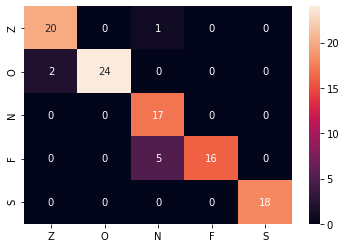

In [11]:
show_confusion(
    label_encoder.inverse_transform(y_val),
    label_encoder.inverse_transform(preds),
)